# Pneumonia Classification

In [1]:
# Ensuring running on TensorFlow 2.X
%tensorflow_version 2.x

# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf

# Check on versioning and gpu usage
print(f"TensorFlow version\t: {tf.__version__}")
print(f"GPU check\t: {tf.test.gpu_device_name()}")

# Check on what GPU we use
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

TensorFlow version	: 2.2.0-rc2
GPU check	: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10090402346289007116, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8737124107470840170
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6639422915548257168
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7304675328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7722219698460552878
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

# Connect to My Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
%cd /gdrive/My Drive/Bangkit

/gdrive/My Drive/Bangkit


# Import Library

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

color = sns.color_palette()
%matplotlib inline
seed_number = 24

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
root = "data/"
print(f"Main directories\t: {os.listdir(root)}")
input_dir = os.path.join(root, "chest_xray")
print(f"Dataset sub-directories\t: {os.listdir(input_dir)}")
print(f"Train set directory\t: {os.listdir(os.path.join(input_dir, 'train'))}")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Main directories	: ['chest_xray']
Dataset sub-directories	: ['__MACOSX', 'chest_xray', 'test', 'train', 'val']
Train set directory	: ['NORMAL', 'PNEUMONIA']


In [0]:
# Import packages for data handling
import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

In [0]:
# Import deep learning package (tensorflow)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [0]:
# Set seed nunmber to all packages
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

# Divide data set
Train, Test, Val





In [8]:
# Create train, val and test directories
train_dir = os.path.join(input_dir, 'train')
val_dir = os.path.join(input_dir, 'val')
test_dir = os.path.join(input_dir, 'test')

dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
label_name = os.listdir(os.path.join(input_dir, 'train'))
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(glob.glob(os.path.join(val, label, "*.jpeg")))
        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

           train  val  test
NORMAL      1341    8   234
PNEUMONIA   3875    8   390


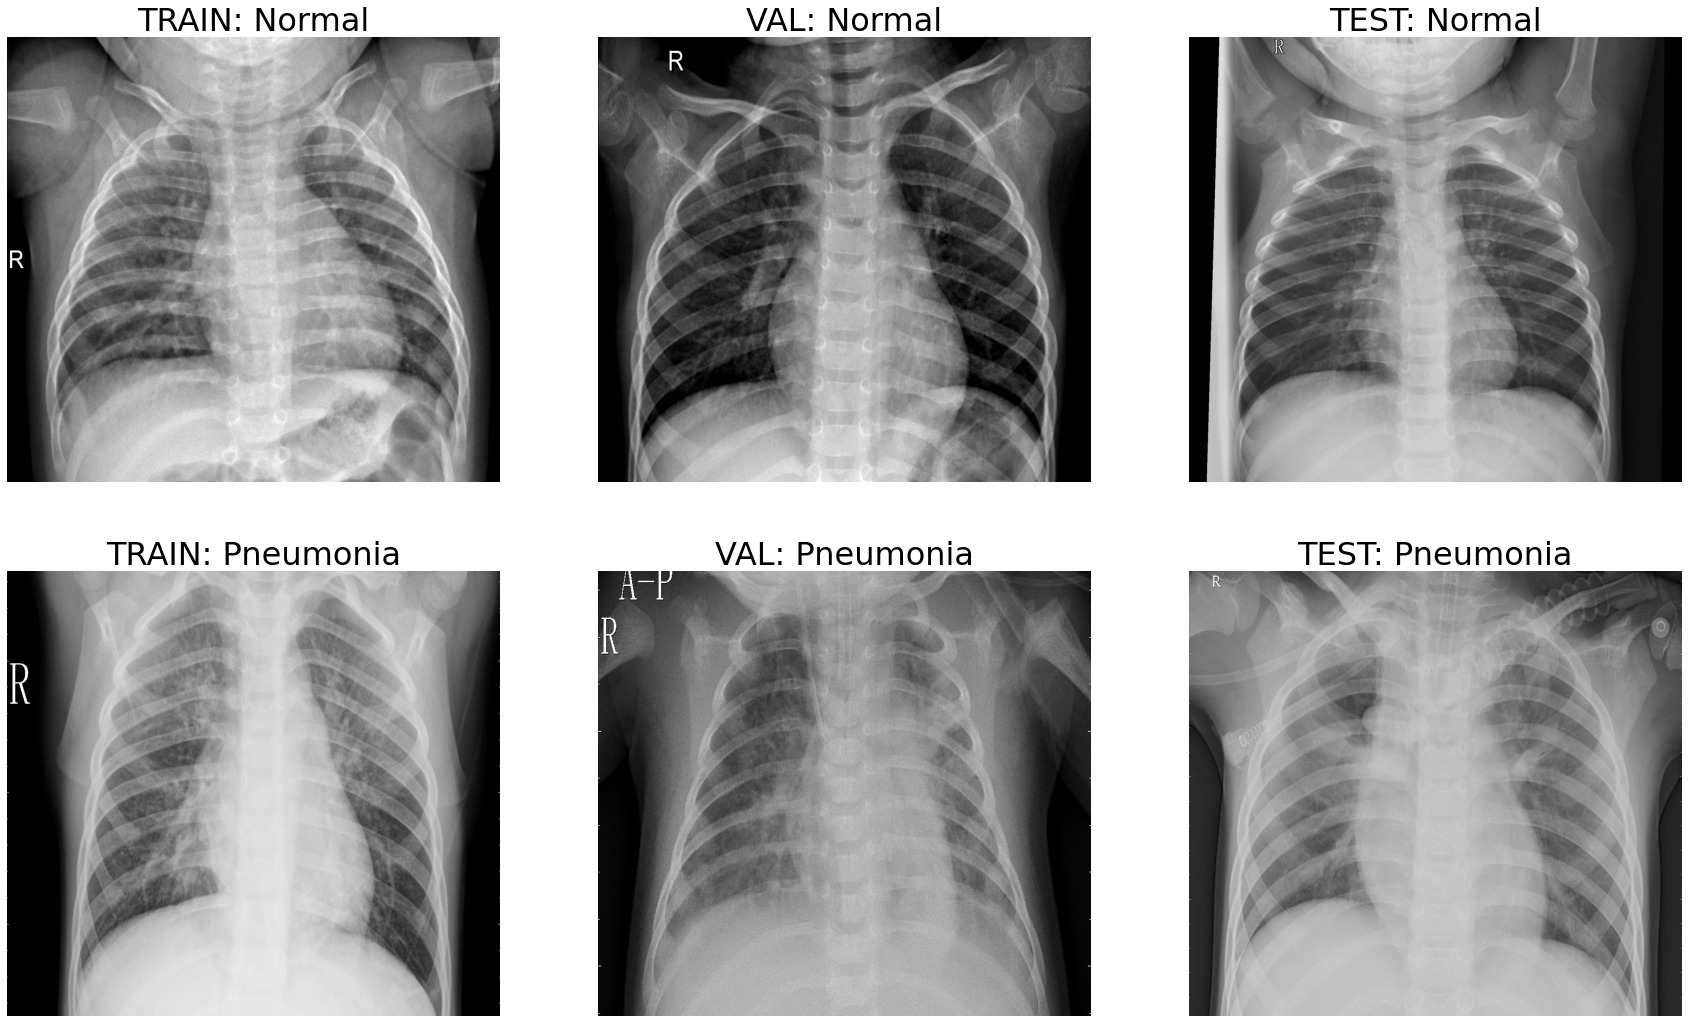

In [9]:
# Visualizing some of the data set
num_classes = len(label_name)
f, ax = plt.subplots(num_classes, 3, figsize=(30, 18))

for k in range(num_classes*3):
    j, i = k//3, k%3  # Image indexing
    
    img = imread(img_disp_df.iloc[j, i])
    ax[j, i].imshow(img, cmap='gray')
    ax[j, i].set_title(f"{img_disp_df.columns[i].upper()}: {img_disp_df.index[j].capitalize()}", fontsize=32)
    ax[j, i].axis('off')
    ax[j, i].set_aspect('auto')
plt.show()

# Preprocessing Image

In [0]:
# Instantiate data generator for training procedure
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 5,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.05,
                                   shear_range = 0.1,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./ 255)

In [11]:
# Define dataset properties
train_batch_size = 32
val_batch_size = 32
img_width = 299
img_height = 299

# Generate dataset for train, val and test
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = train_batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = val_batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

test_gen = test_datagen.flow_from_directory(test_dir,
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            target_size = (img_width, img_height),
                                            seed = seed_number,
                                            shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
# Displaying the dataset generator information
print(f'Train set batch shape\t: {next(train_gen)[0].shape}')
print(f'Val set batch shape\t: {next(val_gen)[0].shape}')
print(f'Test set batch shape\t: {next(test_gen)[0].shape}')

Train set batch shape	: (32, 299, 299, 3)
Val set batch shape	: (16, 299, 299, 3)
Test set batch shape	: (1, 299, 299, 3)


# Check GPU

In [13]:
print('Using GPU:', tf.test.is_gpu_available())

if tf.test.is_gpu_available():
  print('GPU name :', tf.test.gpu_device_name())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Using GPU: True
GPU name : /device:GPU:0


# Model
Transfer Learning using VGG16

In [0]:
def get_model() :  
  pretrain_net = vgg16.VGG16(input_shape = (img_width, img_height, 3),weights='imagenet', include_top=False)
  result = pretrain_net.output
  result = GlobalAveragePooling2D()(result)
  # add a fully-connected layer
  result = Dense(512, activation='relu')(result)
  # and a fully connected output/classification layer
  result = Dense(1, activation='sigmoid')(result)
  predictions = Model(inputs=pretrain_net.input, outputs= result, name='vgg16_pneumonia')
  return predictions

In [19]:
model = get_model()
model.summary()

Model: "vgg16_pneumonia"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)   

In [0]:
train_id = "train10"  # ID of the training procedure
num_epochs = 20  # Set the number of epochs to train
learning_rate = 1e-4  # Set the learning rate to use

model.compile(optimizer = Adam(lr=learning_rate),
              loss = 'binary_crossentropy',
              metrics = ['acc'])


# Define model callback
save_dir = os.path.join("../output", train_id)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

cont_filepath = "vgg16-epoch_{epoch:02d}.hdf5"
cont_checkpoint = ModelCheckpoint(os.path.join(save_dir, cont_filepath))

best_filepath = "vgg16-best.hdf5"
best_checkpoint = ModelCheckpoint(os.path.join(save_dir, best_filepath),
                                  save_best_only=True,
                                  save_weights_only=True)

# Instantiate tensorboard
log_dir = os.path.join(save_dir, "logs")
use_tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=1,
                              update_freq="batch")

# Instantiate learning rate scheduler with Plateau method
plateau_scheduler = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, 
                                      min_delta= 0.005, min_lr=5e-7)

# Displaying tensorboard
#%tensorboard --logdir log_dir

In [21]:
history = model.fit(train_gen,
                    epochs = num_epochs,
                    steps_per_epoch = set_length['train'] // train_batch_size,
                    validation_data = val_gen,
                    validation_steps = 1,
                    callbacks = [cont_checkpoint,
                                 best_checkpoint]
                   )

Epoch 1/20
163/163 [==============================] - 1843s 11s/step - loss: 0.2704 - acc: 0.8798 - val_loss: 0.7742 - val_acc: 0.6250
Epoch 2/20
163/163 [==============================] - 210s 1s/step - loss: 0.1730 - acc: 0.9293 - val_loss: 0.3583 - val_acc: 0.7500
Epoch 3/20
163/163 [==============================] - 209s 1s/step - loss: 0.1130 - acc: 0.9576 - val_loss: 0.1683 - val_acc: 0.9375
Epoch 4/20
163/163 [==============================] - 211s 1s/step - loss: 0.0995 - acc: 0.9634 - val_loss: 0.0512 - val_acc: 1.0000
Epoch 5/20
163/163 [==============================] - 213s 1s/step - loss: 0.0875 - acc: 0.9695 - val_loss: 0.4286 - val_acc: 0.8125
Epoch 6/20
163/163 [==============================] - 215s 1s/step - loss: 0.0763 - acc: 0.9705 - val_loss: 0.2615 - val_acc: 0.8125
Epoch 7/20
163/163 [==============================] - 217s 1s/step - loss: 0.0722 - acc: 0.9743 - val_loss: 0.1281 - val_acc: 1.0000
Epoch 8/20
163/163 [==============================] - 219s 1s/step 

In [0]:
history_df = pd.DataFrame.from_dict(history.history)
history_df.to_csv(os.path.join(save_dir, "history.csv"), index=False)

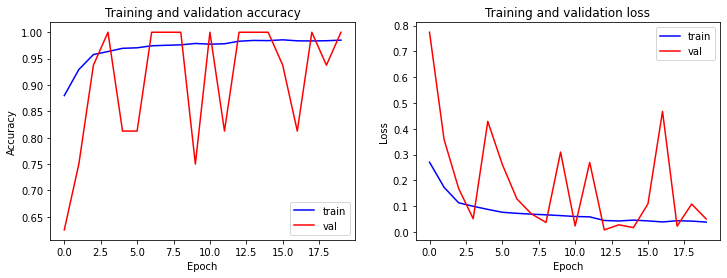

In [23]:
# Plotting the train results
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()


# Result Evaluation

In [24]:
# Test set accuracy and loss
test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

# Calculate prediction
threshold = 0.5  # Define the sigmoid threshold for True or False
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))
y_pred = np.zeros(y_pred_value.shape)

y_pred[y_pred_value > threshold] = 1
y_true = test_gen.classes

# Sanity check on the y_pred and y_true value
print(f"Label\t\t: {y_true[:10]}")
print(f"Prediction\t: {y_pred[:10]}")

624/624 [==============================] - 238s 381ms/step - loss: 0.3327 - acc: 0.9311
Test results Accuracy: 93.11% and Loss: 93.11
624/624 [==============================] - 13s 21ms/step
Label		: [0 0 0 0 0 0 0 0 0 0]
Prediction	: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


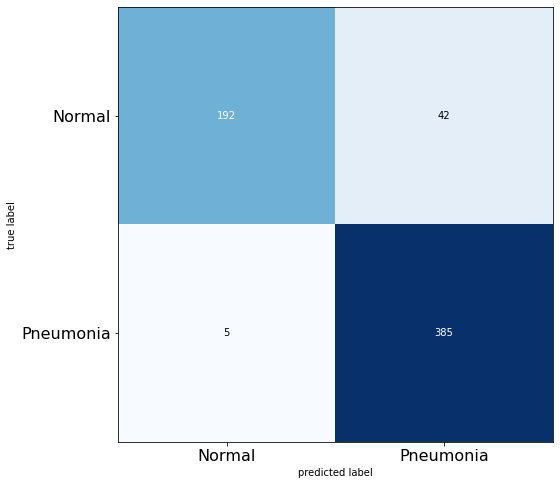

Report Summary:
Precision	: 90.16%
Recall		: 98.72%
F1 Score	: 94.25%


In [25]:
# Confusion matrix result
confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

# Precision and Recall metrics
tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)
print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

# Classification report
#print(classification_report(y_true, y_pred, target_names=label_name))